In [ ]:
%matplotlib inline

import tarfile

In [ ]:
from pathlib import Path

In [ ]:
import lnPi
import lnPi.stability
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# front matters

In [ ]:
# create metadata frame
meta = pd.read_csv(
    "./ref_sim_web/meta.txt",
    sep=":\\s+",
    squeeze=True,
    header=None,
    names=[None, "values"],
    index_col=0,
    engine="python",
)  # , squeeze=True)


table = pd.read_csv("./ref_sim_web/table.txt", sep="\\s+")
volume = float(meta.V)

root = Path()
paths = list(root.glob("**/*.tar.gz"))


def parse_path(path):
    s = path.name.split(".")[1].replace("t", "")
    return float(s[0] + "." + s[1:])


df_list = (
    pd.DataFrame([{"kT": parse_path(path), "path": path} for path in paths])
    .merge(table, on="kT")
    .assign(volume=volume)
    .assign(num_phases_max=2)
)

df_list

,kT,path,Nmin,Nmax,lnzsim,volume,num_phases_max
0,1.20,ref_sim_web/mmlapps.nist.gov/srs/LJ_PURE/lj.t1...,0,390,-2.902929,512.0,2
1,0.75,ref_sim_web/mmlapps.nist.gov/srs/LJ_PURE/lj.t0...,0,475,-5.400601,512.0,2
2,0.80,ref_sim_web/mmlapps.nist.gov/srs/LJ_PURE/lj.t0...,0,470,-4.937419,512.0,2
3,1.10,ref_sim_web/mmlapps.nist.gov/srs/LJ_PURE/lj.t1...,0,400,-3.245568,512.0,2
4,1.45,ref_sim_web/mmlapps.nist.gov/srs/LJ_PURE/lj.t1...,0,370,-1.940905,512.0,2
5,1.00,ref_sim_web/mmlapps.nist.gov/srs/LJ_PURE/lj.t1...,0,425,-3.823078,512.0,2
6,0.90,ref_sim_web/mmlapps.nist.gov/srs/LJ_PURE/lj.t0...,0,465,-4.200008,512.0,2
7,0.95,ref_sim_web/mmlapps.nist.gov/srs/LJ_PURE/lj.t0...,0,465,-3.867387,512.0,2
8,1.05,ref_sim_web/mmlapps.nist.gov/srs/LJ_PURE/lj.t1...,0,415,-3.436560,512.0,2
9,1.50,ref_sim_web/mmlapps.nist.gov/srs/LJ_PURE/lj.t1...,0,370,-1.568214,512.0,2


In [ ]:
import lnPi


def tag_phases2(x):
    if len(x) > 2:
        msg = "bad tag function"
        raise ValueError(msg)
    argmax0 = np.array([xx.local_argmax()[0] for xx in x])
    return np.where(argmax0 <= x[0].shape[0] / 2, 0, 1)


def load_path(path):
    f = tarfile.open(path)
    lnpi = []
    energy = []

    for member in f.getnames():
        if "p_macro" in member:
            d = lnpi
            name = "lnpi"
        else:
            d = energy
            name = "energy"

        d.append(
            pd.read_csv(f.extractfile(member), names=["n_0", name], sep="\\s+")
            .set_index("n_0")[name]
            .to_xarray()
        )
    return lnpi, energy

In [ ]:
# single analysis

In [ ]:
def get_ref(df_list, slc=None):
    if slc is None:
        slc = slice(None)

    for _i, g in df_list.iterrows():
        path = g["path"]
        state_kws = {"beta": 1.0 / g["kT"], "volume": g["volume"], "temp": g["kT"]}
        lnz = g.lnzsim
        lnpi_all, energy_all = load_path(path)

        for lnpi, energy in zip(lnpi_all[slc], energy_all[slc]):
            ref = lnPi.MaskedlnPiDelayed.from_data(
                data=lnpi.values,
                mask=None,
                lnz=lnz,
                lnz_data=lnz,
                state_kws=state_kws,
                extra_kws={"PE": energy.values},
                fill_value=np.nan,
            ).zeromax()

            yield ref


def get_collection(ref):
    phase_creator = lnPi.segment.PhaseCreator(
        nmax=2, nmax_peak=4, ref=ref, merge_kws={"efac": 0.8}, tag_phases=tag_phases2
    )
    build_phases = phase_creator.build_phases_mu([None])

    lnz_range = ref.lnz[0] + np.array([-10, +10])
    lnzs = np.linspace(lnz_range[0], lnz_range[1], 20)

    return build_phases, lnPi.CollectionlnPi.from_builder(lnzs, build_phases)


def get_stability(build_phases, o):
    try:
        o.spinodal(2, build_phases)
        o.binodal(2, build_phases)
        spin = o.spinodal.access
        bino = o.binodal.access
    except:
        spin = None
        bino = None
    return spin, bino


# def get_table(spin, ref=None):
#     return (
#         spin.xge.table(['dens','betaOmega','pressure','PE'], default_keys=[], ref=ref)
#         .to_dataframe()
#     )

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
L_spin = []
L_bino = []
for ref in tqdm(get_ref(df_list, slc=slice(None, 1)), total=len(df_list)):
    build_phases, o = get_collection(ref)
    spin, bino = get_stability(build_phases, o)

    if spin is not None:
        L_spin.append(
            spin.xge.table(
                ["dens", "betaOmega", "pressure", "PE"], default_keys=[], ref=ref
            ).to_dataframe()
        )
    if bino is not None:
        L_bino.append(
            bino.xge.table(
                ["dens", "betaOmega", "pressure", "PE"], default_keys=[], ref=ref
            ).to_dataframe()
        )

In [ ]:
df_spin = pd.concat(L_spin)
df_bino = pd.concat(L_bino)

In [ ]:
df = pd.read_csv("binodal.csv")
df.head()

,component,phase,beta,volume,temp,mu_0,density,pressure,energy,lnz
0,0,0,0.833333,512.0,1.20,-3.636708,0.100375,0.077234,-0.855508,-3.030590
1,0,1,0.833333,512.0,1.20,-3.636708,0.563140,0.077234,-3.871047,-3.030590
2,0,0,1.333333,512.0,0.75,-4.262522,0.003630,0.002636,-0.042503,-5.683363
3,0,1,1.333333,512.0,0.75,-4.262522,0.821441,0.002636,-5.905438,-5.683363
4,0,0,1.250000,512.0,0.80,-4.156566,0.006103,0.004647,-0.067583,-5.195707


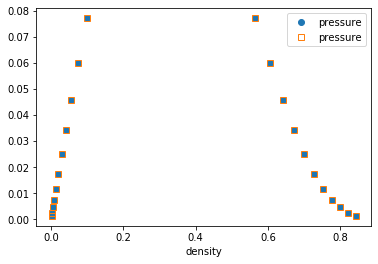

In [ ]:
(df_bino.plot("dens", "pressure", marker="o", ls="None"))

# (
#     df_spin
#     .query('phase==spinodal')
#     .plot('dens','pressure', marker='^', ls='None', ax=plt.gca())
# )


df.plot("density", "pressure", marker="s", ls="None", ax=plt.gca(), mfc="None")

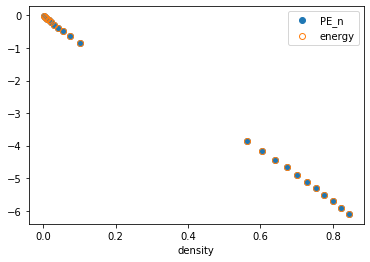

In [ ]:
(
    df_bino.assign(n=lambda x: x["dens"] * x["volume"])
    .assign(PE_n=lambda x: x["PE"] / x["n"])
    .plot("dens", "PE_n", marker="o", ls="None")
)

df.plot("density", "energy", marker="o", ls="None", mfc="None", ax=plt.gca())

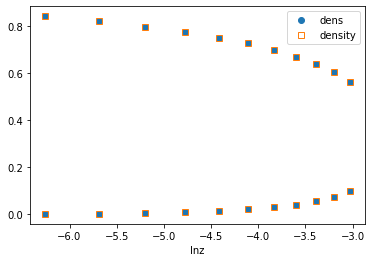

In [ ]:
(df_bino.reset_index().plot("lnz_0", "dens", marker="o", ls="None"))

df.plot("lnz", "density", marker="s", ls="None", mfc="None", ax=plt.gca())